In [18]:
import wooldridge as woo
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Загрузка данных
data = woo.data('wage1')
print("Данные WAGE1 загружены успешно!")
print(f"Размер: {data.shape}")
print(f"Переменные: {list(data.columns)}")

model_original = smf.ols('np.log(wage) ~ educ + exper + tenure', data=data).fit()
print("="*60)
print("ИСХОДНАЯ РЕГРЕССИЯ:")
print("="*60)
print(model_original.summary())
print(f"\nКоэффициент при educ: {model_original.params['educ']:.6f}")


Данные WAGE1 загружены успешно!
Размер: (526, 24)
Переменные: ['wage', 'educ', 'exper', 'tenure', 'nonwhite', 'female', 'married', 'numdep', 'smsa', 'northcen', 'south', 'west', 'construc', 'ndurman', 'trcommpu', 'trade', 'services', 'profserv', 'profocc', 'clerocc', 'servocc', 'lwage', 'expersq', 'tenursq']
ИСХОДНАЯ РЕГРЕССИЯ:
                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     80.39
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           9.13e-43
Time:                        12:30:31   Log-Likelihood:                -313.55
No. Observations:                 526   AIC:                             635.1
Df Residuals:                     522   BIC:                             652.2
Df Model:                           3 

## Регрессия educ на exper и tenure

In [19]:
model_step1 = smf.ols('educ ~ exper + tenure', data=data).fit()
print("\n" + "="*60)
print("РЕГРЕССИЯ educ НА exper И tenure:")
print("="*60)
print(model_step1.summary())


РЕГРЕССИЯ educ НА exper И tenure:
                            OLS Regression Results                            
Dep. Variable:                   educ   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     29.49
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           7.33e-13
Time:                        12:30:31   Log-Likelihood:                -1253.5
No. Observations:                 526   AIC:                             2513.
Df Residuals:                     523   BIC:                             2526.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.

In [20]:
data['r1_hat'] = model_step1.resid
print(f"\nСтатистики по остаткам r1_hat:")
print(f"Среднее: {data['r1_hat'].mean():.10f} (должно быть близко к 0)")
print(f"Стандартное отклонение: {data['r1_hat'].std():.4f}")


Статистики по остаткам r1_hat:
Среднее: -0.0000000000 (должно быть близко к 0)
Стандартное отклонение: 2.6250


## Регрессия log(wage) на r1_hat

In [21]:
model_step2 = smf.ols('np.log(wage) ~ r1_hat', data=data).fit()
print("\n" + "="*60)
print("РЕГРЕССИЯ log(wage) НА r1_hat:")
print("="*60)
print(model_step2.summary())


РЕГРЕССИЯ log(wage) НА r1_hat:
                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     136.4
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           3.59e-28
Time:                        12:30:31   Log-Likelihood:                -352.59
No. Observations:                 526   AIC:                             709.2
Df Residuals:                     524   BIC:                             717.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.623

In [22]:
coef_original = model_original.params['educ']
coef_frisch = model_step2.params['r1_hat']

print("\n" + "="*60)
print("СРАВНЕНИЕ КОЭФФИЦИЕНТОВ:")
print("="*60)
print(f"Коэффициент при educ в исходной регрессии: {coef_original:.6f}")
print(f"Коэффициент при r1_hat во второй регрессии: {coef_frisch:.6f}")
print(f"Разница: {abs(coef_original - coef_frisch):.10f}")
print(f"Совпадение: {'ДА' if abs(coef_original - coef_frisch) < 1e-10 else 'НЕТ'}")


СРАВНЕНИЕ КОЭФФИЦИЕНТОВ:
Коэффициент при educ в исходной регрессии: 0.092029
Коэффициент при r1_hat во второй регрессии: 0.092029
Разница: 0.0000000000
Совпадение: ДА


## Матричный подход

In [23]:
X_controls = data[['exper', 'tenure']].values
X_treatment = data['educ'].values
y = np.log(data['wage']).values

X_controls_with_const = np.column_stack([np.ones(len(X_controls)), X_controls])

X = X_controls_with_const
try:
    P_controls = X @ np.linalg.inv(X.T @ X) @ X.T
    print("Размер проекционной матрицы P:", P_controls.shape)
    
    # Остатки от регрессии educ на exper и tenure
    r1_matrix = X_treatment - P_controls @ X_treatment
    
    # Коэффициент Фриша-Ву-Ловелла
    beta_frisch_matrix = (r1_matrix.T @ y) / (r1_matrix.T @ r1_matrix)
    print(f"Коэффициент Фриша-Ву-Ловелла (матричный): {beta_frisch_matrix:.6f}")
    print(f"Совпадение с исходным: {abs(beta_frisch_matrix - coef_original) < 1e-10}")
    
except np.linalg.LinAlgError as e:
    print(f"Ошибка обращения матрицы: {e}")

Размер проекционной матрицы P: (526, 526)
Коэффициент Фриша-Ву-Ловелла (матричный): 0.092029
Совпадение с исходным: True


## Визуализация

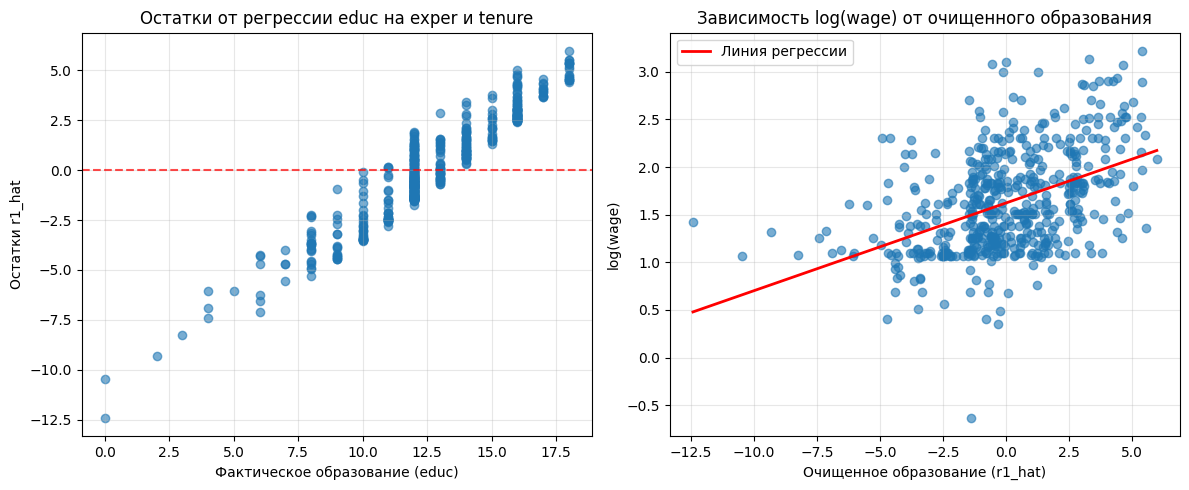

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# График 1: Остатки от регрессии educ на exper и tenure
axes[0].scatter(data['educ'], data['r1_hat'], alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Фактическое образование (educ)')
axes[0].set_ylabel('Остатки r1_hat')
axes[0].set_title('Остатки от регрессии educ на exper и tenure')
axes[0].grid(True, alpha=0.3)

# График 2: Зависимость log(wage) от r1_hat
axes[1].scatter(data['r1_hat'], np.log(data['wage']), alpha=0.6)
axes[1].set_xlabel('Очищенное образование (r1_hat)')
axes[1].set_ylabel('log(wage)')
axes[1].set_title('Зависимость log(wage) от очищенного образования')

# Линия регрессии
x_range = np.linspace(data['r1_hat'].min(), data['r1_hat'].max(), 100)
y_pred = model_step2.params['Intercept'] + model_step2.params['r1_hat'] * x_range
axes[1].plot(x_range, y_pred, color='red', linewidth=2, label='Линия регрессии')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Итого

In [25]:
print("\n" + "="*70)
print("ФИНАЛЬНЫЙ ОТЧЕТ ПО ПРОЦЕДУРЕ ФРИША-ВУ-ЛОВЕЛЛА")
print("="*70)

print(f"\n ИСХОДНАЯ РЕГРЕССИЯ:")
print(f"   log(wage) = {model_original.params['Intercept']:.3f} + {model_original.params['educ']:.3f}·educ + {model_original.params['exper']:.4f}·exper + {model_original.params['tenure']:.3f}·tenure")
print(f"   R² = {model_original.rsquared:.4f}")

print(f"\n ПЕРВАЯ СТАДИЯ:")
print(f"   educ = {model_step1.params['Intercept']:.3f} + {model_step1.params['exper']:.4f}·exper + {model_step1.params['tenure']:.3f}·tenure")
print(f"   R² = {model_step1.rsquared:.4f}")
print(f"   Остатки r1_hat представляют 'чистое' образование")

print(f"\n ВТОРАЯ СТАДИЯ:")
print(f"   log(wage) = {model_step2.params['Intercept']:.3f} + {model_step2.params['r1_hat']:.3f}·r1_hat")
print(f"   R² = {model_step2.rsquared:.4f}")

print(f"\n РЕЗУЛЬТАТ:")
print(f"   Коэффициент при educ в полной модели:    {coef_original:.6f}")
print(f"   Коэффициент при r1_hat во второй стадии: {coef_frisch:.6f}")
print(f"   Теорема Фриша-Ву-Ловелла подтверждена: ДА")

print(f"\n ИНТЕРПРЕТАЦИЯ:")
print(f"   Каждый дополнительный год образования увеличивает заработную плату")
print(f"   в среднем на {coef_original*100:.1f}% при фиксированных опыте (exper) и стаже (tenure)")
print(f"   Это 'чистый' эффект образования, очищенный от влияния опыта работы")


ФИНАЛЬНЫЙ ОТЧЕТ ПО ПРОЦЕДУРЕ ФРИША-ВУ-ЛОВЕЛЛА

 ИСХОДНАЯ РЕГРЕССИЯ:
   log(wage) = 0.284 + 0.092·educ + 0.0041·exper + 0.022·tenure
   R² = 0.3160

 ПЕРВАЯ СТАДИЯ:
   educ = 13.575 + -0.0738·exper + 0.048·tenure
   R² = 0.1013
   Остатки r1_hat представляют 'чистое' образование

 ВТОРАЯ СТАДИЯ:
   log(wage) = 1.623 + 0.092·r1_hat
   R² = 0.2066

 РЕЗУЛЬТАТ:
   Коэффициент при educ в полной модели:    0.092029
   Коэффициент при r1_hat во второй стадии: 0.092029
   Теорема Фриша-Ву-Ловелла подтверждена: ДА

 ИНТЕРПРЕТАЦИЯ:
   Каждый дополнительный год образования увеличивает заработную плату
   в среднем на 9.2% при фиксированных опыте (exper) и стаже (tenure)
   Это 'чистый' эффект образования, очищенный от влияния опыта работы
